In [2]:
!git clone https://github.com/SiyuanChen726/BreastAgeNet.git

Cloning into 'BreastAgeNet'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 295 (delta 65), reused 8 (delta 7), pack-reused 165 (from 1)
Receiving objects: 100% (295/295), 24.67 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [3]:
!apt-get update
!apt-get install -y openslide-tools libopenslide0
!pip install openslide-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,224 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,514 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Package

In [5]:
# Download the files with corrected Google Drive links
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53' -O 'BreastAgeNet_bestModel.pt'


--2024-11-30 06:15:45--  https://drive.google.com/uc?export=download&id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53
Resolving drive.google.com (drive.google.com)... 74.125.68.139, 74.125.68.138, 74.125.68.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53&export=download [following]
--2024-11-30 06:15:45--  https://drive.usercontent.google.com/download?id=1tDfFXZvB6PASPW-4OMrBU-HQo7optH53&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9995011 (9.5M) [application/octet-stream]
Saving to: ‘BreastAgeNet_bestModel.pt’

BreastAgeNet_bestMo 100%[===================>]   9.53M 

In [1]:
import os
import sys
sys.path.append('/content/BreastAgeNet')

import openslide
import h5py
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


from utils_vis import *
from utils_train import *

In [2]:
ckpt_name = "BreastAgeNet_bestModel.pt"
n_feats = get_dim_input(model_name = "UNI")

model = BreastAgeNet(n_feats, attention="MultiHeadAttention", n_classes=3, n_heads=8, n_latent=512, embed_attn=True)
model.load_state_dict(torch.load(ckpt_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

<ipython-input-2-aa43e33e99df>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_name))


cuda


In [ ]:
clinic_df = pd.read_csv("/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/DATA/clinicData/AllCohorts.csv")
clinic_df = clinic_df.loc[clinic_df["cohort"]=="development", :].copy()

valid_patches = []
for fea_pt in clinic_df.h5df.values:
    with h5py.File(fea_pt, "r") as file:
        bag = np.array(file["embeddings"])
        bag = np.squeeze(bag)
        img_id = np.array(file["patch_id"])
    img_id = [i.decode("utf-8") for i in img_id]
    bag_df = pd.DataFrame(bag)
    bag_df.index = img_id

    csv_pt =  os.path.join(Path(fea_pt).parent, Path(fea_pt).stem.split('_bagFeature_')[0]+'_patch.csv')
    df = pd.read_csv(csv_pt)
    valid_id = list(df['patch_id'][df['TC_epi'] > 0.9])
    valid_id = list(set(valid_id) & set(bag_df.index))
    valid_patches.extend(valid_id)
print(len(valid_patches))

valid_wsis = ["_".join(i.split("_")[:3]) for i in valid_patches]
print(len(np.unique(valid_wsis)))

a, b = np.unique(valid_wsis, return_counts=True)
filtered_a = [i for i, count in zip(a, b) if count >= 5]
print(len(filtered_a))
print(len(np.unique([i.split("_")[0] for i in filtered_a])))
clinic_df = clinic_df[clinic_df["wsi_id"].isin(filtered_a)]
print("Filtered DataFrame length:", len(clinic_df))
print("Unique age groups and counts:", np.unique(clinic_df["age_group"], return_counts=True))


print(len(valid_patches))
valid_patches = [i for i in valid_patches if "_".join(i.split("_")[:3]) in filtered_a]
print(len(valid_patches))

In [ ]:
df = clinic_df.copy() # file containing all {wsi_id}_UNI.h5 files for the dataset
df['h5df'] = [Path(i) for i in df["h5df"]]

valid_patches = valid_patches # select patches with TC_epi > 0.9
test_dblock = DataBlock(blocks = (TransformBlock, CategoryBlock),
               get_x = ColReader('h5df'),
               get_y = ColReader('age_group'),
               item_tfms = MILBagTransform(df.h5df, bag_size, valid_patches))

test_dls = test_dblock.dataloaders(df, bs=bag_size, shuffle=False)
dataloaders = test_dls.test_dl(df, with_labels=True)

In [ ]:
# Initialize test loader, assume clinic_df is pre-defined
phase = 'test'
model.eval()

predicted_ranks = []
truelabels = []
df = pd.DataFrame()  # Initialize empty DataFrame

# Loop through the test data
for repeat in range(10):
    for (patch_ids, inputs), labels in tqdm(dataloaders):  # Ensure 'dataloaders' is correctly defined elsewhere
        patch_ids = np.array(patch_ids)  # Shape: (150, 7)
        patch_ids = np.transpose(patch_ids)  # Shape: (7, 150)
        patch_ids = patch_ids.flatten()  # Flattened to shape (1050,)

        # Enable gradients only if in training phase
        with torch.set_grad_enabled(phase == 'train'):
            logits, embeddings, attentions = model(inputs)

            attentions = attentions.view(-1, attentions.shape[-1])  # Flatten attentions
            embeddings = embeddings.view(-1, embeddings.shape[-1])  # Flatten embeddings
            probs = torch.sigmoid(logits)  # Shape: [batch_size, n_classes]
            binary_predictions = (probs > 0.5).int()  # Shape: [batch_size, n_classes]
            ranks = binary_predictions.sum(dim=1)  # Sum the predictions to get a rank score
            predicted_ranks += ranks.tolist()  # Accumulate predicted ranks
            truelabels += labels.tolist()  # Accumulate true labels

        # Concatenate patch_ids, embeddings, and attentions
        # Assuming patch_ids, embeddings, and attentions are of compatible shapes
        combined_data = np.column_stack((repeat, patch_ids, embeddings.cpu().numpy(), attentions.cpu().numpy()))  # Convert to numpy
        dfi = pd.DataFrame(combined_data, columns=['repeat'] + ['patch_id'] +
                                                    [f'embedding_{i}' for i in range(embeddings.shape[1])] +
                                                    [f'attention_{i}' for i in range(attentions.shape[1])])

        # Append new data to the main DataFrame
        df = pd.concat([df, dfi], axis=0, ignore_index=True)

# Remove duplicates from the final DataFrame
df = df.drop_duplicates()

In [ ]:
MAE = np.abs(truelabels - np.array(predicted_ranks)).mean()
print(f'Mean Absolute Error (MAE): {MAE}')

In [ ]:
# average for each WSI

In [ ]:
# vote for each patient

from scipy.special import expit  # For sigmoid function

# Step 1: Convert 'branch_0', 'branch_1', 'branch_2' to numeric (if necessary)
outputs_WSI['branch_0'] = pd.to_numeric(outputs_WSI['branch_0'], errors='coerce')
outputs_WSI['branch_1'] = pd.to_numeric(outputs_WSI['branch_1'], errors='coerce')
outputs_WSI['branch_2'] = pd.to_numeric(outputs_WSI['branch_2'], errors='coerce')

# Step 2: Group by 'wsi_id' and calculate the mean for each branch across repeats
averaged_data = outputs_WSI.groupby('wsi_id')[['branch_0', 'branch_1', 'branch_2']].mean().reset_index()

# Step 3: Apply sigmoid to the averaged values
averaged_data['sigmoid_0'] = expit(averaged_data['branch_0'])  # Sigmoid for branch 0
averaged_data['sigmoid_1'] = expit(averaged_data['branch_1'])  # Sigmoid for branch 1
averaged_data['sigmoid_2'] = expit(averaged_data['branch_2'])  # Sigmoid for branch 2

# Step 4: Convert sigmoid values to binary (0 or 1)
averaged_data['binary_0'] = (averaged_data['sigmoid_0'] >= 0.5).astype(int)
averaged_data['binary_1'] = (averaged_data['sigmoid_1'] >= 0.5).astype(int)
averaged_data['binary_2'] = (averaged_data['sigmoid_2'] >= 0.5).astype(int)

# Step 5: Sum the binary predictions to get the final prediction
averaged_data['final_prediction'] = averaged_data[['binary_0', 'binary_1', 'binary_2']].sum(axis=1)

# Display the results (only final prediction for simplicity)
print(averaged_data[['wsi_id', 'final_prediction']])



In [ ]:
df["wsi_id"] = [i.split("_")[0] for i in list(df["patch_id"])]
df = pd.merge(df, clinic_df, on="wsi_id")

In [ ]:
# Select the columns that start with 'embedding_'
tsne_df = df.sample(frac=0.5, random_state=42).copy()

embedding_columns = [col for col in tsne_df.columns if col.startswith('embedding_')]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(tsne_df.loc[:, embedding_columns])

tsne_df["tsne1"] = projections[:,0]
tsne_df["tsne2"] = projections[:,1]

In [ ]:
n_clusters = 4  # Adjust this as necessary
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tsne_df['Cluster'] = kmeans.fit_predict(tsne_df.loc[:, embedding_columns].copy())

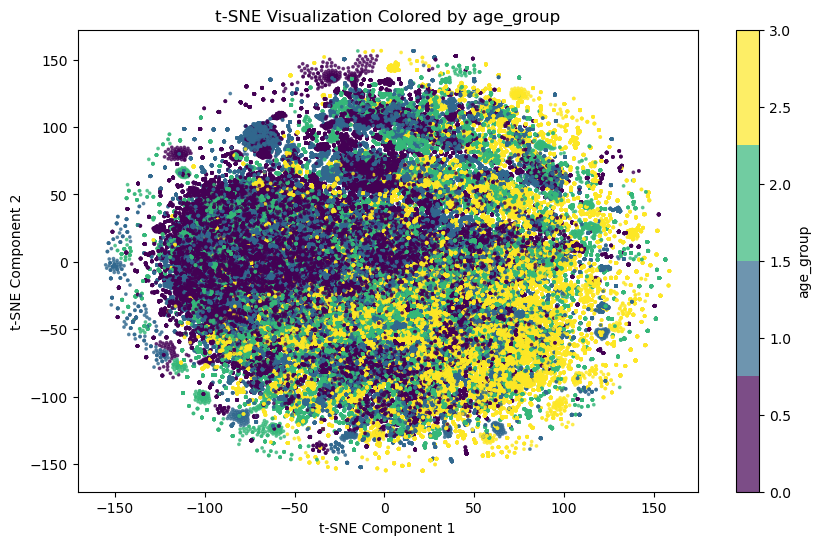

In [ ]:
plot_tsne(tsne_df, color='age_group', point_size=3, save_pt=None)

/scratch/users/k21066795/conda/torch_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/users/k21066795/conda/torch_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/users/k21066795/conda/torch_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/users/k21066795/conda/torch_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

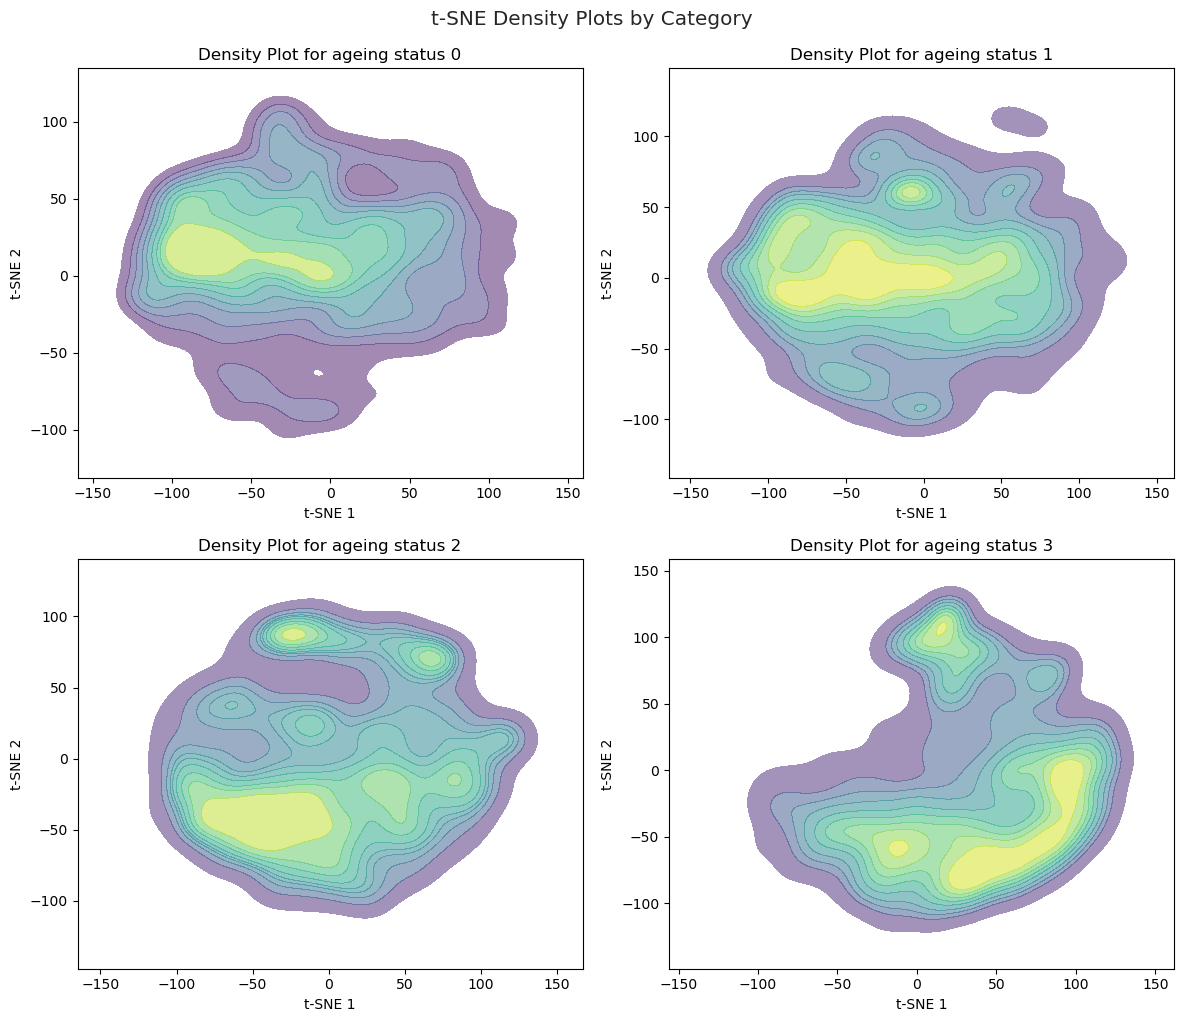

In [ ]:
plot_density_by_age(fea_df, max_categories=4, save_pt=None)

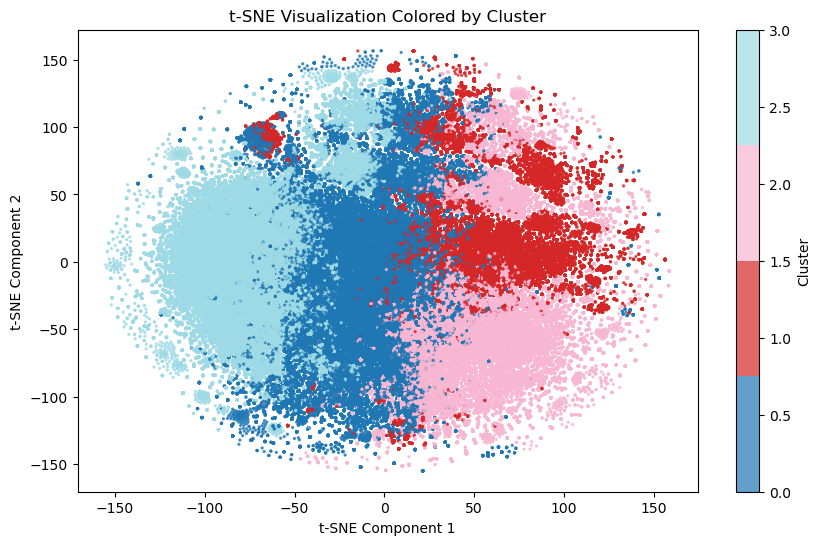

In [ ]:
def plot_tsne(fea_df, color='age_group', point_size=3, save_pt=None):
    """
    Creates a t-SNE plot colored by a specified feature.

    Parameters:
    - fea_df (DataFrame): DataFrame containing the t-SNE components and the coloring feature.
    - color (str): Column name in `fea_df` used for coloring the points. Can be 'age_group' or 'cluster'.
    - save_pt (str, optional): If provided, the plot will be saved to this file path.
    """
    plt.figure(figsize=(10, 6))

    # Handle color based on 'age_group' or 'cluster'
    if color == "age_group":
        cmap = plt.get_cmap('viridis', fea_df['age_group'].nunique())  # Use 'viridis' colormap for age group
    elif color == "Cluster":
        n_clusters = len(np.unique(fea_df['Cluster']))
        cmap = plt.get_cmap('tab20', n_clusters)  # Use 'tab20' colormap for clusters

    # Ensure there are no NaN values in the color column for plotting
    if fea_df[color].isnull().any():
        print(f"Warning: NaN values found in {color}. These will be excluded from the plot.")
        fea_df = fea_df.dropna(subset=[color])

    # Create scatter plot
    scatter = plt.scatter(
        fea_df["tsne1"],
        fea_df["tsne2"],
        c=fea_df[color],
        cmap=cmap,
        alpha=0.7,
        s=point_size  # Adjust point size for better visibility
    )

    # Add a color bar
    plt.colorbar(scatter, label=f'{color}')

    # Set plot titles and labels
    plt.title(f't-SNE Visualization Colored by {color}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    # If save_pt is provided, save the plot
    if save_pt:
        plt.savefig(save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1)

    # Display the plot
    plt.show()


plot_tsne(tsne_df, color='Cluster', point_size=2, save_pt=None)

In [ ]:
full_image = paste_HE_on_tsne(fea_df, WSI_folder, max_dim=100, n_samples=1000, image_size=(4000, 3000), random_state=42)

plt.figure(figsize = (16,12))

# # Calculate and add cluster labels at the centroids
# centroids = tsne_df.groupby('Cluster')[['tsne1', 'tsne2']].mean()
# for cluster, (x, y) in centroids.iterrows():
#     plt.text(x, y, str(cluster), fontsize=12, fontweight='bold',
#              ha='center', va='center', color='black',
#              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.imshow(np.flipud(full_image), origin='upper')

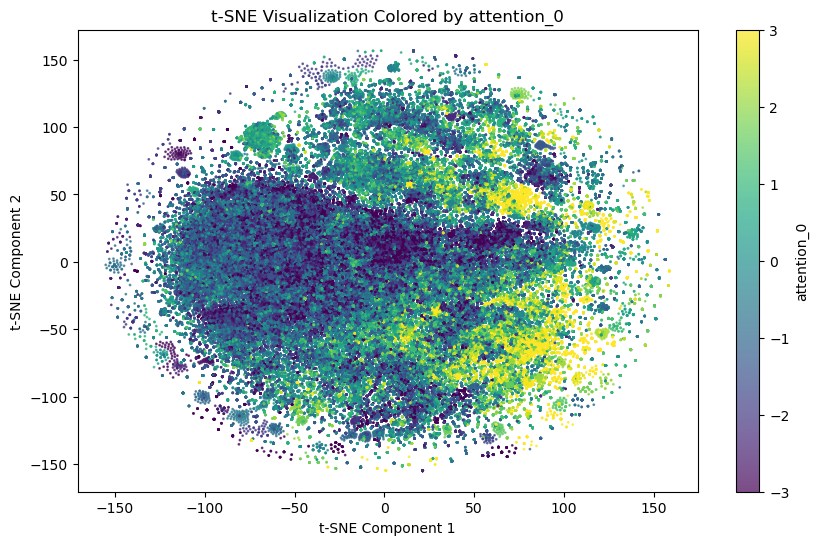

In [ ]:
plot_tsne(tsne_df, color='attention_0', point_size=1, vmin=-3, vmax=3, save_pt=None)

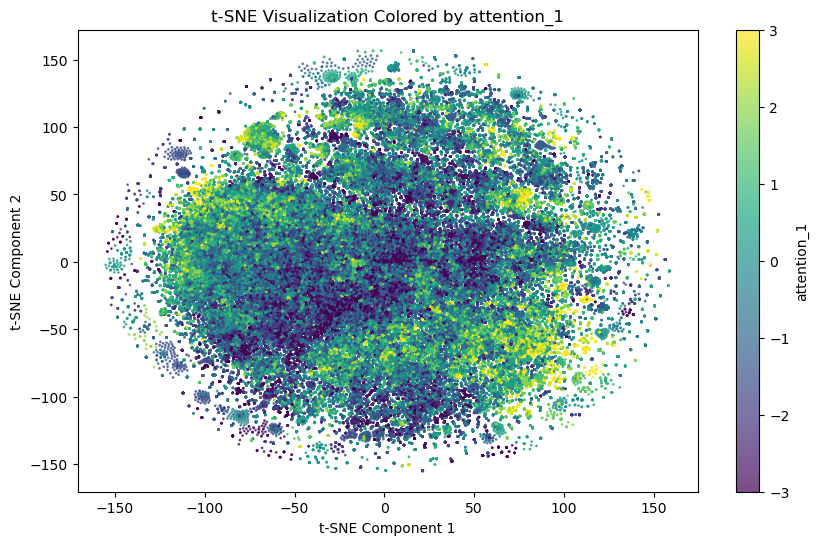

In [ ]:
plot_tsne(tsne_df, color='attention_1', point_size=1, vmin=-3, vmax=3, save_pt=None)

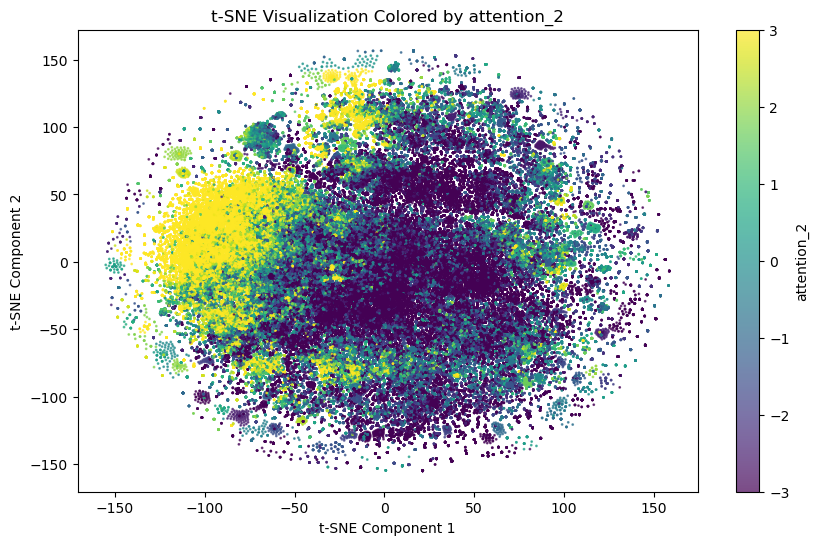

In [ ]:
plot_tsne(tsne_df, color='attention_2', point_size=1, vmin=-3, vmax=3, save_pt=None)